In [204]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy
import time
#from diagonal import *
%matplotlib inline

In [611]:
class Diagonal:
    def __init__(self,n,d,precision='single',sparse=True):
        self.n = n
        self.d = d
        self.area = n*d
        self.dims = 2
        self.shape = [self.n*self.d,self.n*self.d]
        self.precision = np.float32 if 'single' else np.float64
        self.sparse= sparse
        self.table = self._create_table()
        self.matrix = self._create_matrix()
        self.basis = self._create_basis()
        self.row_based = self._create_row_representation()
        
    
    def _create_basis(self):
        return np.split(np.array(self.table[1][:self.area]),self.d)
    
    def _create_row_representation(self):
        row_wise = np.zeros((self.n,self.area))
        for ii,i in enumerate(np.repeat(range(self.matrix.shape[1]),self.d)):
            row_wise[:,ii] = self.matrix[:,i][ii%self.d::self.d]
        return row_wise
    def _create_table(self):
        ''' 
            This function will create a lookup table of indicies of where the values in the sparse
            representation exist in the full matrix
        '''
        rows = np.repeat(range(self.area),self.n)
        columns = [list(range(i,self.area,self.d)) for i in range(self.d)]
        columns = [i for c in columns for i in c] * self.n
        return rows,columns
    
    def _create_zero_matrix(self):
        return np.zeros((self.shape)).astype(self.precision)
        
    
    def _create_matrix(self):
        
        if 1 in[self.n,self.d]:
            raise AssertionError('n or d cannot be equal to 1')
        populated = self.n**2 * self.d
        values = np.random.randn(populated).astype(self.precision)
        sparse= np.reshape(values,(self.area, self.n))
        return sparse
    
    def from_dense(self,arr):
        ''' 
            This function will take a dense representation of the sparse matrix
            and recreate the sparse matrix
        '''
        matrix = self._create_zero_matrix()
        matrix[self.table] = arr.flatten()
        return matrix
    
    def _sparse_mm(self,y,left=False,batch = True):
        if batch:
            if left:
                batched = np.vstack([y[:,b] for b in self.basis])
                batched = np.reshape(batched,(self.d,y.shape[-1],self.n))
            else:
                batched = np.vstack([y[b,:] for b in self.basis])
                batched = np.reshape(batched,(self.d,self.n,y.shape[-1]))
            #batched = np.vstack([batched for _ in range(self.n)])
        else:
            batched=y
        if left:
            return np.vstack([np.dot(batched[ii%self.d],i) for ii,i in enumerate(self.row_based.T)]).T
        else:
            return np.vstack([np.dot(i,batched[ii%self.d]) for ii,i in enumerate(diag.matrix)])
        
    @staticmethod
    def _swap_elements(l,i,j):
        new = l.copy()
        new[i],new[j] = j,i
        return new
    
    def _create_diag(self):
        return np.repeat(np.arange(0,self.n),self.d)
    
    def get_permutation_dense(self):
        diags = np.repeat(np.arange(0,self.n),self.d)
        updated = self.row_based.copy()
        for c in range(updated.shape[1]):
            max_idx = np.argmax(np.abs(self.row_based[diags[c]:,c]))
            max_idx += diags[c]
            if (max_idx != diags[c]) and (max_idx > diags[c] ):

                order = self._swap_elements(list(range(updated.shape[0])),max_idx,diags[c])
                basis = self.basis[c%self.d]
                updated[:,basis] = updated[:,basis][[order],:]
        return updated
    
    @staticmethod
    def create_pivot(mat):
        mat_size = mat.shape[0]
        p_blank = np.eye(mat_size)
        for c in range(mat_size):
            row = max(range(c, mat_size), key=lambda i: abs(mat[i,c]))
            if c != row:
                p_blank[[c,row]] = p_blank[[row,c]]
        return p_blank
        
    
    def mm(self,y,x=None,sparse=True,left=False,batch=True):
        if sparse:
            return self._sparse_mm(y,left=left,batch=batch)
        else:
            assert x is not None
            return np.dot(x,y)
        
   
    def to_dense(self,mat):
        dense = np.zeros((self.area,self.n))
        for i in range(self.d):
            dense[self.basis[i%self.d],:] = mat[i%self.d::self.d,self.basis[i%self.d]]
        return dense
    def _backwards_solve(self,A,b):
        diags = self._create_diag()
        x = np.zeros(b.shape)
        for i in range(b.shape[0])[::-1]:
            basis = self.basis[i%self.d][::-1]
            subset = [s for s in basis if s >i]
            x[i] = (b[i] -(A[i][diags[i]+1:] *x[subset][::-1].T).sum()) / A[i,diags[i]]
        return x
        
    
    def backwards(self,A,b):
        return np.hstack([self._backwards_solve(A,b[:,i])[...,None] for i in range(len(b))])
        
    def _forward_solve(self,A,column):
            x = np.zeros(column.shape)
            diags = self._create_diag()
            for i in range(column.shape[0]):
                basis = self.basis[i%self.d]
                subset = [s for s in basis if s <i]
                x[i] = (column[i] - (A[i][:diags[i]] *x[subset].T).sum()) / A[i,diags[i]]
            return x
    def forward(self,A,b):
        return np.hstack([self._forward_solve(A,b[:,i])[...,None] for i in range(len(b))])
    def plu(self):
        L = np.eye(self.area)
        U = np.zeros((self.area,self.area))
        #P = self.create_pivot(self.from_dense(self.matrix))
        PA = self.get_permutation_dense()

        for j in range(self.area):

            basis = self.basis[j%self.d]
            Uupdatedable = [b for b in basis if b<=j]
            Lupdatedable = [b for b in basis if b>j]

            for ii,i in enumerate(basis):
                if i <= j:
                    if len(Uupdatedable) == 1:
                        value = PA[ii,j]
                    else:
                        value= PA[ii,j] - (U[Uupdatedable[:ii+(1-j%2)],j] *L[basis[ii],Uupdatedable[:ii+(1-j%2)]]).sum()
                    U[i,j] = value

                
            #for ii,i in enumerate(basis):
                if i > j:
                    if len(Lupdatedable)>self.d:
                        value = PA[ii,j] / U[j,j]
                    else:
                        value = (PA[ii,j] -(L[basis[ii],range(j)] * U[range(j),j]).sum()) / U[j,j]
                    L[i,j] = value


        return(PA,L,U)
    
            
        
        

In [1]:
import math
import numpy as np

In [2]:
n = 300
d = 300
z = 1000

In [4]:
1000**2

1000000

In [5]:
diag = Diagonal(n,d)
y = np.zeros((d,n,z))
x = diag.mm(y,batch=False)

In [3]:
zz = np.dot(np.random.randn(n*d,n*d),np.random.randn(n*d,n*d))

MemoryError: 

In [61]:
np.allclose(diag.mm(x,sparse=True,left=False),diag.mm(x,new_normal,sparse=False))

True

In [62]:
np.allclose(diag.mm(x,sparse=True,left=True),diag.mm(new_normal,x,sparse=False,left=True))

True

In [28]:
%%timeit
np.dot(new_normal,x)

7.88 s ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
import time
start = time.time()
diag.mm(x,new_normal,sparse=False)
end = time.time()
print(end - start)

7.910259246826172


In [18]:
def return_time(function,x,kwargs={}):
    start = time.time()
    function(x,**kwargs)
    end = time.time()
    return end-start

In [3]:
def return_time(function,args,kwargs={}):
    start = time.time()
    function(*args,**kwargs)
    end = time.time()
    return end-start

In [ ]:
def return_time(function,args,kwargs={}):
    start = time.time()
    function(*args,**kwargs)
    end = time.time()
    return end-start

In [45]:
return_time(diag.mm,(x),kwargs={'sparse':True})

3.076077461242676

In [ ]:
dot_times = []
for i in range(2,200):
    
    x = np.random.randn(i**2,i**2)
    y = np.random.randn(i**2,i**2)
    dot_times.append(return_time(np.dot,(x,y)))
    if i % 10 == 0:
        print(i)
    

10
20
30
40
50
60
70
80
90


In [49]:
sparse_times = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    sparse_times.append(return_time(diag.mm,x,kwargs={'sparse':True}))
    if i % 10 == 0:
        print(i)
    
    

10
20
30
40
50
60
70
80
90
100


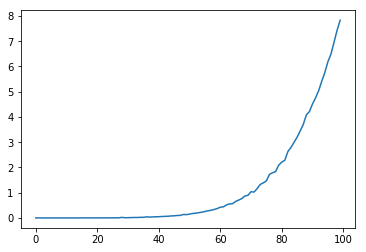

In [41]:
plt.plot(dot_times)

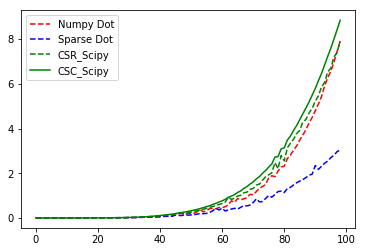

In [68]:
plt.plot(dot_times,'r--',sparse_times,'b--',scipy_times,'g--',scipy_times_csc,'g')
plt.legend(['Numpy Dot', 'Sparse Dot','CSR_Scipy','CSC_Scipy'], loc='upper left')

In [20]:
import time

In [21]:
scipy_lu = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    mat = d.from_dense(d.matrix)
    scipy_lu.append(return_time(la.lu,x))
    if i % 10 == 0:
        print(i)

10
20
30
40
50
60
70
80
90
100


In [ ]:
scipy_lu = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    mat = d.from_dense(d.matrix)
    scipy_lu.append(return_time(la.lu,x))
    if i % 10 == 0:
        print(i)

In [ ]:
base_lu = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    mat = diag.from_dense(diag.matrix)
    base_lu.append(return_time(lu_decomp,mat))
    if i % 10 == 0:
        print(i)

10
20
30
40


In [39]:
diag_lu = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    start = time.time()
    _=diag.plu()
    end = time.time()
    diag_lu.append(end-start)
    if i % 10 == 0:
        print(i)

10
20
30
40
50
60
70
80
90
100


In [29]:
print(scipy_lu[-1])

8.743863105773926


In [35]:
d.n

10

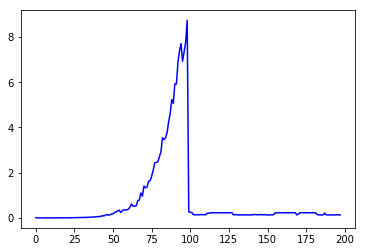

In [44]:
plt.plot(scipy_lu,'b')

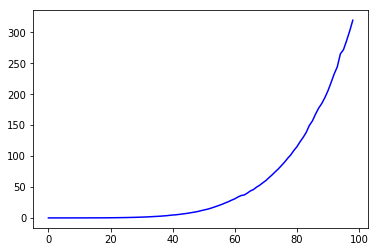

In [42]:
plt.plot(diag_lu,'b')

In [56]:
from scipy import sparse,dot

In [63]:
scipy_times = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    sparse_matrix = sparse.csr_matrix(diag.from_dense(diag.matrix))
    scipy_times.append(return_time(sparse.csr_matrix.dot,(sparse_matrix,x)))
    if i % 10 == 0:
        print(i)

10
20
30
40
50
60
70
80
90
100


In [65]:
scipy_times_csc = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    sparse_matrix = sparse.csc_matrix(diag.from_dense(diag.matrix))
    scipy_times_csc.append(return_time(sparse.csc_matrix.dot,(sparse_matrix,x)))
    if i % 10 == 0:
        print(i)

10
20
30
40
50
60
70
80
90
100


In [246]:
#d = Diagonal(3,2)
#mat = d.from_dense(d.matrix)
#PA = get_permutation_dense(d)
U = np.zeros(d.row_based.shape)
L = np.zeros(d.row_based.shape)
diags = np.repeat(np.arange(0,d.n),d.d)
for dd,i in enumerate(diags):
    L[i%3,dd] = 1.
    
#P = create_pivot(d.from_dense(d.matrix))
#PA = get_permutation_dense(d)


In [256]:
j=1
basis = d.basis[j%d.d]
updatedable = [b for b in basis if b<=j]

In [258]:
for ii,i in enumerate(basis):
    if i <= j:
        if len(updatedable) == 1:
            value = PA[ii,j]
        else:
            value= PA[ii,j] - (U[:ii+(1-j%2),j] *L[ii,:ii+(1-j%2)]).sum()
        print(value)
        U[ii,j] = value

-1.517400860786438


In [266]:
updatedable = [b for b in basis if b>j]
for ii,i in enumerate(basis):
    if i > j:
        if len(updatedable)>d.d:
            print("shortcut")
            value = PA[ii,j] / U[j,j]
        else:
            print( (L[ii,range(j%d.d)] , U[range(j%d.d),j]))
            value = (PA[ii,j] -(L[[ii],range(j)] * U[range(j),j]).sum()) / U[diags[j],j]
            
            print(value)

        #L[ii,j] = value

(array([0.63742576]), array([-1.51740086]))
-0.29683069784846505
(array([0.07055672]), array([-1.51740086]))
-0.8780089178754102


In [267]:
basis

array([1, 3, 5])

array([1, 0, 2])

In [261]:
print(PA)

[[ 0.85997415 -1.51740086  1.0397054  -0.12726651 -1.8338536  -0.70463437]
 [ 0.54816967 -0.51681924 -0.41988409  1.76475978  1.01285851 -0.22566311]
 [ 0.06067695  1.22522867  0.29368633  1.3415972   1.45098865  1.43674076]]


In [265]:
print(L)

[[1.         1.         0.         0.         0.         0.        ]
 [0.63742576 0.         1.         1.         0.         0.        ]
 [0.07055672 0.         0.         0.         1.         1.        ]]


In [238]:
for j in range(d.area):
    basis = d.basis[j%d.d]
    updatedable = [b for b in basis if b<=j]
    for ii,i in enumerate(basis):
        if i <= j:
            if len(updatedable) == 1:
                value = PA[ii,j]
            else:
                value= PA[ii,j] - (U[:ii+(1-j%2),j] *L[ii,:ii+(1-j%2)]).sum()
            #print(value)
            U[ii,j] = value
    updatedable = [b for b in basis if b>j]
    for ii,i in enumerate(basis):
        if i > j:
            if len(updatedable)>d.d:
                #print("shortcut")
                value = PA[ii,j] / U[j,j]
            else:
                #print( (PA[ii,j] -(L[ii,range(j%d.d)] * U[range(j%d.d),j]).sum()), U[diags[j],j])
                value = (PA[ii,j] -(L[ii,range(j%d.d)] * U[range(j%d.d),j]).sum()) / U[diags[j],j]

                #print(value)

            L[ii,j] = value

In [252]:
print(U)

[[0.85997415 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


In [253]:
print(u)

[[ 0.85997415  0.          1.0397054   0.         -1.8338536   0.        ]
 [ 0.         -1.51740086  0.         -0.12726651  0.         -0.70463437]
 [ 0.          0.         -1.08261909  0.          2.18180403  0.        ]
 [ 0.          0.          0.          1.80810612  0.          0.01433188]
 [ 0.          0.          0.          0.          2.02440699  0.        ]
 [ 0.          0.          0.          0.          0.          0.85796261]]


In [254]:
print(l)

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.        ]
 [ 0.63742576  0.          1.          0.          0.          0.        ]
 [ 0.          0.34059506  0.          1.          0.          0.        ]
 [ 0.07055672  0.         -0.20351399  0.          1.          0.        ]
 [ 0.         -0.8074522   0.          0.68515645  0.          1.        ]]


In [271]:
print(l)

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.        ]
 [ 0.63742576  0.          1.          0.          0.          0.        ]
 [ 0.          0.34059506  0.          1.          0.          0.        ]
 [ 0.07055672  0.         -0.20351399  0.          1.          0.        ]
 [ 0.         -0.8074522   0.          0.68515645  0.          1.        ]]


In [255]:
print(L)

[[1.         1.         0.         0.         0.         0.        ]
 [0.63742576 0.         1.         1.         0.         0.        ]
 [0.07055672 0.         0.         0.         1.         1.        ]]


In [241]:
pa,l,u = d.plu()

In [167]:
print(L)

[[1.         1.         0.         0.         0.         0.        ]
 [0.02926848 0.         1.         1.         0.         0.        ]
 [0.93516406 0.         0.         0.         1.         1.        ]]


In [87]:

def get_permutation_dense(diag):
    diags = np.repeat(np.arange(0,diag.n),diag.d)
    updated = diag.row_based.copy()
    for c in range(updated.shape[1]):
        max_idx = np.argmax(np.abs(d.row_based[diags[c]:,c]))
        max_idx += diags[c]
        if (max_idx != diags[c]):
            order = swap_elements(list(range(updated.shape[0])),max_idx,diags[c])
            basis = diag.basis[c%diag.d]
            updated[:,basis] = updated[:,basis][[order],:]
    return updated
        
    
    
    

In [41]:
def create_pivot(mat):
    mat_size = mat.shape[0]
    p_blank = np.eye(mat_size)
    for c in range(mat_size):
        row = max(range(c, mat_size), key=lambda i: abs(mat[i,c]))
        if c != row:
            p_blank[[c,row]] = p_blank[[row,c]]
        
            
    return p_blank

In [89]:
def swap_elements(l,i,j):
    new = l.copy()
    new[i],new[j] = j,i
    return new

In [124]:
def pivot_matrix(M):
    """Returns the pivoting matrix for M, used in Doolittle's method."""
    m = len(M)

    # Create an identity matrix, with floating point values                                                                                                                                                                                            
    id_mat = [[float(i ==j) for i in range(m)] for j in range(m)]

    # Rearrange the identity matrix such that the largest element of                                                                                                                                                                                   
    # each column of M is placed on the diagonal of of M                                                                                                                                                                                               
    for j in range(m):
        row = max(range(j, m), key=lambda i: abs(M[i][j]))
        if j != row:
            # Swap the rows                                                                                                                                                                                                                            
            id_mat[j], id_mat[row] = id_mat[row], id_mat[j]

    return id_mat


In [17]:
d.basis

[array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
 array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
 array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92]),
 array([ 3, 13, 23, 33, 43, 53, 63, 73, 83, 93]),
 array([ 4, 14, 24, 34, 44, 54, 64, 74, 84, 94]),
 array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]),
 array([ 6, 16, 26, 36, 46, 56, 66, 76, 86, 96]),
 array([ 7, 17, 27, 37, 47, 57, 67, 77, 87, 97]),
 array([ 8, 18, 28, 38, 48, 58, 68, 78, 88, 98]),
 array([ 9, 19, 29, 39, 49, 59, 69, 79, 89, 99])]

In [40]:
def lu_decomp(mat):
    n = mat.shape[0]
    L = np.eye(n)
    U = np.zeros((n,n))
    P = create_pivot(mat)
    PA = P.dot(mat)
    for j in range(n):
        for i in range(j+1):
            #print('U')
            s1 = sum(U[k,j] * L[i,k] for k in range(i))
            #print(i,j,s1)
            U[i,j] = PA[i,j]- s1
            #print(U)
        for i in range(j, n):
            #print('L')
            s2 = sum(U[k,j] * L[i,k] for k in range(j))
            #print(i,j,s2,U[j,j])
            L[i,j] = (PA[i,j] - s2) / U[j,j]
            #print(L)
    return(P,L,U)

    

In [15]:
def plu(diag,PA):
    L = np.eye(diag.area)
    U = np.zeros((diag.area,diag.area))
    #P = create_pivot(diag.from_dense(diag.matrix))
    #PA = get_permutation_dense(diag)
    
    for j in range(diag.area):
    
        basis = diag.basis[j%diag.d]
        updatedable = [b for b in basis if b<=j]

        for ii,i in enumerate(basis):
            if i <= j:
                if len(updatedable) == 1:
                    value = PA[ii,j]
                else:
                    value= PA[ii,j] - (U[updatedable[:ii+(1-j%2)],j] *L[basis[ii],updatedable[:ii+(1-j%2)]]).sum()
                U[i,j] = value

        updatedable = [b for b in basis if b>j]
        for ii,i in enumerate(basis):
            if i > j:
                if len(updatedable)>1:
                    value = PA[ii,j] / U[j,j]
                else:
                    value = (PA[ii,j] -(U[basis[:ii],j] * L[updatedable,basis[:ii]]).sum()) / U[j,j]

                L[i,j] = value
            
    
    return(PA,L,U)
    
    

In [620]:
d = Diagonal(3,2)
mat = d.from_dense(d.matrix)

In [621]:
PA,L,U = d.plu()

In [452]:
p,l,u = la.lu(mat)

In [622]:
sparse_l = d.to_dense(L)

In [623]:
sparse_u = d.to_dense(U)

In [609]:
b = np.eye(6)

In [580]:
len(b)

6

In [595]:
print(d.forward(sparse_l,b))

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.        ]
 [-0.96037933  0.          1.          0.          0.          0.        ]
 [ 0.          0.37460499  0.          1.          0.          0.        ]
 [ 0.37997333  0.          0.32063421  0.          1.          0.        ]
 [ 0.          0.120649    0.         -0.24214645  0.          1.        ]]


In [624]:
print(d.backwards(sparse_u,b))

[[ 1.33963476  0.          0.01947037  0.         -4.55089446  0.        ]
 [ 0.          1.0619707   0.         -0.70103643  0.         -0.26042726]
 [-0.         -0.         -0.50702325 -0.         -0.06052428 -0.        ]
 [ 0.          0.          0.          0.6593636   0.         -0.22638935]
 [-0.         -0.         -0.         -0.         -3.78363249 -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.48167143]]


In [440]:
b = np.array([[1,2,3,4,5,6],[1,2,3,4,5,6]]).T
solution = np.zeros(b.shape)
#solution[-1] = b[-1]/sparse_u[-1,-1] 

In [482]:
b = np.eye(6)

In [522]:
print(sparse_l)

[[1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.60890064 1.         0.        ]
 [0.35864555 1.         0.        ]
 [0.84581557 2.09154927 1.        ]
 [0.74999222 0.59483319 1.        ]]


In [484]:
print(d.forward(sparse_l,b))

[[ 1.          1.          1.          1.          1.          1.        ]
 [ 0.          1.          0.          0.          0.          0.        ]
 [-0.60890064 -0.60890064  0.39109936 -0.60890064 -0.60890064 -0.60890064]
 [ 0.         -0.35864555  0.          1.          0.          0.        ]
 [ 0.42773012  0.42773012 -1.66381915  0.42773012  1.42773012  0.42773012]
 [ 0.         -0.53665795  0.         -0.59483319  0.          1.        ]]


In [625]:
print(np.linalg.solve(U,b))

[[ 1.33963476  0.          0.01947037  0.         -4.55089446  0.        ]
 [ 0.          1.0619707   0.         -0.70103643  0.         -0.26042726]
 [-0.         -0.         -0.50702325 -0.         -0.06052428 -0.        ]
 [ 0.          0.          0.          0.6593636   0.         -0.22638935]
 [-0.         -0.         -0.         -0.         -3.78363249 -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.48167143]]


In [598]:
b = np.array([0,0,0,0,0,1])

In [607]:
print(solve(sparse_u,b))

[ 0.         -0.34374482  0.          0.68023762  0.         -1.18028791]


In [ ]:
x = np.zeros(b.shape)
for i in range(b.shape[0])[::-1]:
    basis = d.basis[i%d.d][::-1]
    subset = [s for s in basis if s >i]
    x[i] = (b[i] -(sparse_u[i][diags[i]+1:] *x[subset][::-1].T).sum(1)) / sparse_l[i,diags[i]]
return x

In [535]:
b = np.eye(6)
solution = np.zeros(b.shape)
for e,c in enumerate(range(b.shape[1])):
    for i in range(b.shape[0]):
        
        basis = d.basis[i%d.d]
        subset = [s for s in basis if s <i]
        if i in basis:
            solution[i,c] = (b[i,c] - (sparse_l[i][:diags[i]] *solution[subset].T).sum()) / sparse_l[i,diags[i]]

In [605]:
def solve(A,b):
    x = np.zeros(b.shape)
    for i in range(b.shape[0])[::-1]:
        basis = d.basis[i%d.d][::-1]
        subset = [s for s in basis if s >i]
        x[i] = (b[i] -(A[i][diags[i]+1:] *x[subset][::-1].T).sum()) / A[i,diags[i]]
    return x
        

In [546]:
print(np.hstack([solve(sparse_l,b[:,i])[...,None] for i in range(6)]))

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.        ]
 [-0.60890064  0.          1.          0.          0.          0.        ]
 [ 0.         -0.35864555  0.          1.          0.          0.        ]
 [ 0.42773012  0.         -2.09154927  0.          1.          0.        ]
 [ 0.         -0.53665795  0.         -0.59483319  0.          1.        ]]


In [536]:
print(solution)

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.        ]
 [-0.60890064 -0.60890064  0.39109936 -0.60890064 -0.60890064 -0.60890064]
 [ 0.         -0.35864555 -0.35864555  0.64135445 -0.35864555 -0.35864555]
 [ 0.42773012  1.70127582  0.88327224  2.15681793  4.43036362  4.70390932]
 [ 0.         -0.53665795 -0.32332367 -0.70482259 -0.49148831  0.72184596]]


In [ ]:
solution = sparse_l.shape
for i in range(1,b.shape[0]):
    basis = d.basis[i%d.d]
    subset = [s for s in basis if s <i]
    solution[i] = (x[i] - (sparse_l[i][:diags[i]] *solution[subset,:].T).sum(1)) / sparse_l[i,diags[i]]

In [485]:
print(L)

[[1.         0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.60890064 0.         1.         0.         0.         0.        ]
 [0.         0.35864555 0.         1.         0.         0.        ]
 [0.84581557 0.         2.09154927 0.         1.         0.        ]
 [0.         0.74999222 0.         0.59483319 0.         1.        ]]


In [448]:
solution = d.backwards(sparse_u,y)

In [455]:
print(np.dot(p.dot(mat),solution))

[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.98928250e-17
   0.00000000e+00  6.35503145e-17]
 [ 1.47366739e-16  1.47366739e-16 -4.08345267e-16  1.47366739e-16
   1.00000000e+00  1.47366739e-16]
 [ 0.00000000e+00  1.16819178e-16  0.00000000e+00  1.00000000e+00
   0.00000000e+00 -4.09152979e-17]
 [ 2.22044605e-16  2.22044605e-16  1.00000000e+00  2.22044605e-16
  -8.88178420e-16  2.22044605e-16]
 [ 0.00000000e+00  1.24900090e-16  0.00000000e+00 -1.11022302e-16
   0.00000000e+00  1.00000000e+00]]


In [444]:
print(np.linalg.solve(U,b))

[[-13.65727729 -13.65727729]
 [ 43.93688981  43.93688981]
 [ 19.87703467  19.87703467]
 [ 11.56212162  11.56212162]
 [ -6.11669725  -6.11669725]
 [  2.30417512   2.30417512]]


In [434]:
def backwards(self,A,b):
    x = np.zeros(b.shape)
    for i in range(b.shape[0])[::-1]:
        basis = self.basis[i%self.d][::-1]
        subset = [s for s in basis if s >i]
        x[i] = (b[i] -(A[i][diags[i]+1:] *x[subset,:][::-1].T).sum(1)) / A[i,diags[i]]
    return x

In [432]:

    #print(sparse_u[i,diags[i]])
    
    

[6 6] [] []
[5 5] [] []
[4 4] [-1.48755126] [7.0793227]
[3 3] [2.42922992] [-1.88850174]
[2 2] [ 2.06624937 -0.84966171] [4.30046056 7.0793227 ]
[1 1] [-0.63479936 -0.33817631] [-8.00621615 -1.88850174]


In [314]:
print(sparse_u)

[[ 0.93168247 -0.63479936 -0.33817631]
 [ 1.33463264  2.06624937 -0.84966171]
 [ 0.         -0.94771423  2.42922992]
 [ 0.          3.3789068  -1.48755126]
 [ 0.          0.         -2.64760147]
 [ 0.          0.          0.84753871]]


In [271]:
diags = np.repeat(np.arange(0,d.n),d.d)

In [ ]:
def forward(a,x):
    b = np.zeros(x.shape)
    b[0] = a[0,0]
    for i in range(1,b.shape[0]):
        basis = d.basis[i%d.d]
        subset = [s for s in basis if s <i]
        solution[i] = (x[i] - (sparse_l[i][:diags[i]] *solution[subset,:].T).sum(1)) / sparse_l[i,diags[i]]

In [280]:
for i in range(1,solution.shape[0]):
    basis = d.basis[i%d.d]
    subset = [s for s in basis if s <i]
    solution[i] = (b[i] - (sparse_l[i][:diags[i]] *solution[subset,:].T).sum(1)) / sparse_l[i,diags[i]]

In [181]:
for i in range(1,solution.shape[0]):
    basis = d.basis[i%d.d]
    subset = [s for s in basis if s <i]
    print(x[i],sparse_l[i][:diags[i]] ,solution[subset].T,(sparse_l[i][:diags[i]] *solution[subset].T).sum())
    solution[i] = (x[i] - (sparse_l[i][:diags[i]] *solution[subset].T).sum()) / sparse_l[i,diags[i]]
        

2 [] [] 0.0
3 [-0.11596257] [1.] -0.11596256916683961
4 [0.17888942] [2.] 0.3577788300007127
5 [-0.62343041  0.35067001] [1.         3.11596257] 0.4692442153292292
6 [ 0.32108005 -0.5435611 ] [2.         3.64222117] -1.3376096425877981


In [165]:
solution

array([[1.        , 1.        ],
       [2.        , 2.        ],
       [3.23192514, 3.23192514],
       [3.28444234, 3.28444234],
       [3.98018238, 3.98018238],
       [8.28626998, 8.28626998]])

In [167]:
for i in range(1,solution.shape[0]):
    basis = d.basis[i%d.d]
    subset = [s for s in basis if s <i]
    print()
    solution[i] = (x[i] - (sparse_l[i][:diags[i]] *solution[subset,:].T).sum()) / sparse_l[i,diags[i]]
    
    
    

ValueError: operands could not be broadcast together with shapes (0,) (0,2) 

In [21]:
i = 2

In [26]:
(a[i] - (x[:i] * solution[:i])[-1].sum())/x[i,i]

1.5

In [47]:
(a[i] - (x[i][:i] *solution[:i].T).sum()) / x[i,i]

0.6666666666666666

In [50]:
solution

array([[ 2.        ],
       [-0.5       ],
       [ 0.66666667]])

In [31]:
print(x)

[[1 0 0]
 [1 2 0]
 [1 2 3]]


In [32]:
np.linalg.solve(x,a)

array([ 2.        , -0.5       ,  0.66666667])

In [6]:
a = np.array([2,1,3])

In [15]:
solution[0]=2

In [17]:
solution[:1]

array([[2.]])

In [10]:
print(x)

[[1 0 0]
 [1 2 0]
 [1 2 3]]


In [8]:
np.linalg.solve(x,a)

array([ 2.        , -0.5       ,  0.66666667])

In [29]:
L[d.basis]

IndexError: index 4 is out of bounds for axis 0 with size 3

In [40]:
print(np.dot(L,U)[:,0])

[ 1.24610603  0.          0.          0.          0.1129849   0.          0.
  0.          0.46757331  0.          0.          0.          0.08257036
  0.          0.          0.        ]


In [285]:
PA.sum()

2.1676505003124475

In [13]:
np.allclose(PA.sum(),L.dot(U).sum())

True

In [509]:
for i in range(d.area):
    print('column {}'.format(i))
    print(L.dot(U)[:,i].sum())
    print(PA[:,i].sum())
    print('\n')

column 0
-1.2403408587
-1.2403408587


column 1
0.0918840765953
0.0918840765953


column 2
-3.49678850919
-3.49678850919


column 3
-0.375688582659
-0.375688582659


column 4
0.450707294047
0.450707294047


column 5
-0.791108518839
-0.791108518839


column 6
-2.14767384529
-2.14767384529


column 7
-0.0029793381691
-0.0029793381691


